Finish reading data 
(375726L, 3L)
(231216L, 3L)
Finish traing PCAs
-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


AttributeError: 'numpy.ndarray' object has no attribute 'append'

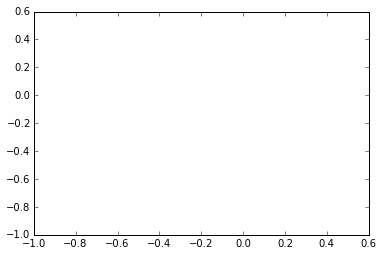

In [5]:
%matplotlib inline

import glob
import os
import numpy as np
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from utils import DATA_DIR, SESSION_NAME, SESSION_DATA, SESSION_EVENTS, \
    from_str_labels_to_id_labels
import xml.etree.ElementTree as ET


def read_project_data():
    project_data = {}
    
    data_length = None
    
    for file_name in glob.glob(os.path.join(DATA_DIR, '*.txt')):
        project_name = file_name[file_name.rfind('/') + 1:]
        project_name = project_name[:len(project_name)-4]
        project_data[project_name] = []


        tree = ET.parse(file_name)

        doc = tree.getroot()


        for session_element in doc.findall('session'):
            session_data = {}

            session_name = session_element.attrib['name']

            session_data[SESSION_NAME] = session_name
            session_data[SESSION_DATA] = []
            session_data[SESSION_EVENTS] = []

            frame_elements = session_element.findall('data/frame')

            for frame_element in frame_elements:
                object_point_elements = frame_element.findall('o')

                point_data = []
                for object_point_element in object_point_elements:
                    for s in object_point_element.text.split(','):
                        point_data.append(float(s))
                        
                if data_length == None:
                    data_length = len(point_data)

                session_data[SESSION_DATA].append(point_data)
            
            '''
            Calculate the difference of data points -> gradient feature
            Move all points to the same coordinations
            '''
            #session_data[SESSION_DATA] = [[(session_data[SESSION_DATA][i][t] - session_data[SESSION_DATA][0][0])\
            #     for t in xrange(data_length)]\
            #     for i in xrange(0, len(session_data[SESSION_DATA]))]
            
            project_data[project_name].append(session_data) 
            
    return data_length, project_data
    
'''
Find planes for projection of data from DATA_DIR 
'''
all_rig_points = []
all_object_points = []

no_of_samples = 0

for file_name in glob.glob(os.path.join(DATA_DIR, '*.txt')):
    tree = ET.parse(file_name)
    doc = tree.getroot()
    for session_element in doc.findall('session'):
        frame_elements = session_element.findall('data/frame')

        for frame_element in frame_elements:
            object_point_elements = frame_element.findall('o')

            rig = object_point_elements[0]
            o1, o2 = object_point_elements[1], object_point_elements[2]

            rig_points = []
            for s in rig.text.split(','):
                rig_points.append(float(s))

            o1_points = []
            for s in o1.text.split(','):
                o1_points.append(float(s))

            o2_points = []
            for s in o2.text.split(','):
                o2_points.append(float(s))


            all_rig_points.append(rig_points)
            all_object_points.append(o1_points)
            all_object_points.append(o2_points)
            
print 'Finish reading data '

# (13 * samples, 3)
all_rig_array = np.array(all_rig_points).reshape((-1, 3))

print (all_rig_array.shape)

# (8 * samples, 3)
all_object_array = np.array(all_object_points).reshape((-1, 3))

print (all_object_array.shape)

'''
PCA for inter-object relationship
This PCA would be an estimation of projecting on the table surface
'''
inter_object_pca = PCA(n_components=2)
all_points = np.concatenate((all_rig_array, all_object_array), axis = 0)

# (13 * samples + 8 * samples, 2)
inter_object_pca.fit(all_points)

'''
PCA for intra-object relationship
'''
intra_object_pca = PCA(n_components=2)

intra_object_pca.fit(all_object_array)

'''
PCA for intra-rig relationship
This would be a good 
'''
intra_rig_pca = PCA(n_components=2)

intra_rig_pca.fit(all_rig_array)

print 'Finish traing PCAs'

In [199]:
data_length = None
_, project_data = read_project_data()

def plot_project(project_name, sessionIndex = 0):
    no_of_points = 8
    colormaps_fig = plt.figure(figsize = (20, 10))
    # Draw the plot
    colormap = plt.cm.gist_ncar
    plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, no_of_points)])
    
    plt.axis ( [-1,2,-1,1] )
    
    labels = ['right_hand_tip', 'left_hand_tip', 'o1_centroid', 'o2_centroid', 
             #'average_shoulders', 'left_hand_on_rig', 'right_hand_on_rig', 
             'o1_corner1', 'o1_corner2','o2_corner1','o2_corner2',]

    session_data = project_data[project_name][sessionIndex]
    print '-----------------------------------'
    print project_name
    print '-----------------------------------'
    point_datas = session_data[SESSION_DATA]

    new_session_datas = []

    for point_data in point_datas:
        new_session_data = []

        "---------------------------------------------"
        # (21, 2)
        inter_object_data = inter_object_pca.transform( np.array(point_data).reshape((-1, 3)) )

        # Centroid of three objects projected using inter_object_pca
        new_session_data.append( (inter_object_data[1] + inter_object_data[7] ) / 2 )
        new_session_data.append( np.average( inter_object_data[5:6], axis = 0 ) )
        new_session_data.append( np.average( inter_object_data[11:12], axis = 0 ) )
        new_session_data.append( np.average( inter_object_data[13:17], axis = 0 ) )
        new_session_data.append( np.average( inter_object_data[17:21], axis = 0 ) )

        "---------------------------------------------"
        # (21, 2)
        intra_rig_data = intra_rig_pca.transform( np.array(point_data).reshape((-1, 3)) )

        # Average of two shoulders
        #new_session_data.append( (intra_rig_data[1] + intra_rig_data[7] ) / 2 )

        # Hand tip left
        #new_session_data.append( intra_rig_data[5] )

        # Hand tip right
        #new_session_data.append( intra_rig_data[11] )

        "---------------------------------------------"
        intra_object_data = intra_object_pca.transform( np.array(point_data).reshape((-1, 3)) )

        # Corners of objects (for each object, just pick two corners)
        new_session_data.append( intra_object_data[13] )
        new_session_data.append( intra_object_data[15] )
        new_session_data.append( intra_object_data[17] )
        new_session_data.append( intra_object_data[19] )

        point_data = np.concatenate( new_session_data )

        new_session_datas.append( point_data )
    
    # (sample_size, 16 )
    new_session_datas = np.array(new_session_datas)

    # 8 different points' trajectories
    handles = []
    for i in xrange(no_of_points):
        x = new_session_datas[:, 2 * i]
        y = new_session_datas[:, 2 * i + 1]
        
        h, = plt.plot(x, y, label = labels[i])

        handles.append(h)
        
    plt.legend(handles=handles)
    
    return new_session_datas

In [13]:
plt.legend()

['C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollacross', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideacross', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullacross', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushacross', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfrollacross', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslidefrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollfrom', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollto', 'C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushfrom']


-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


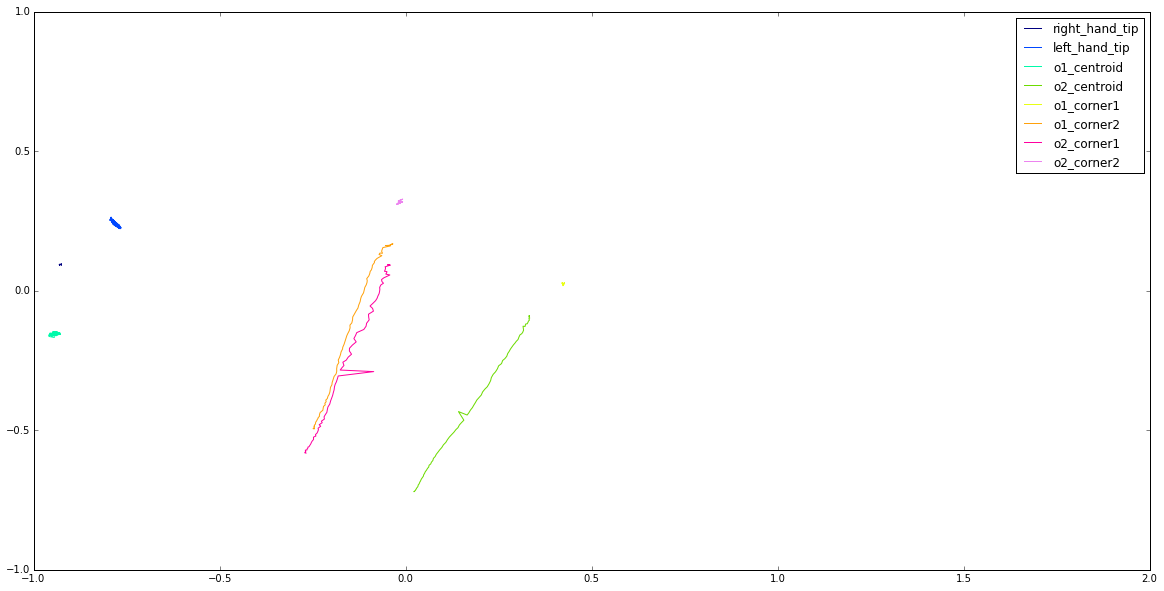

In [200]:
sample = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\rollacross
-----------------------------------


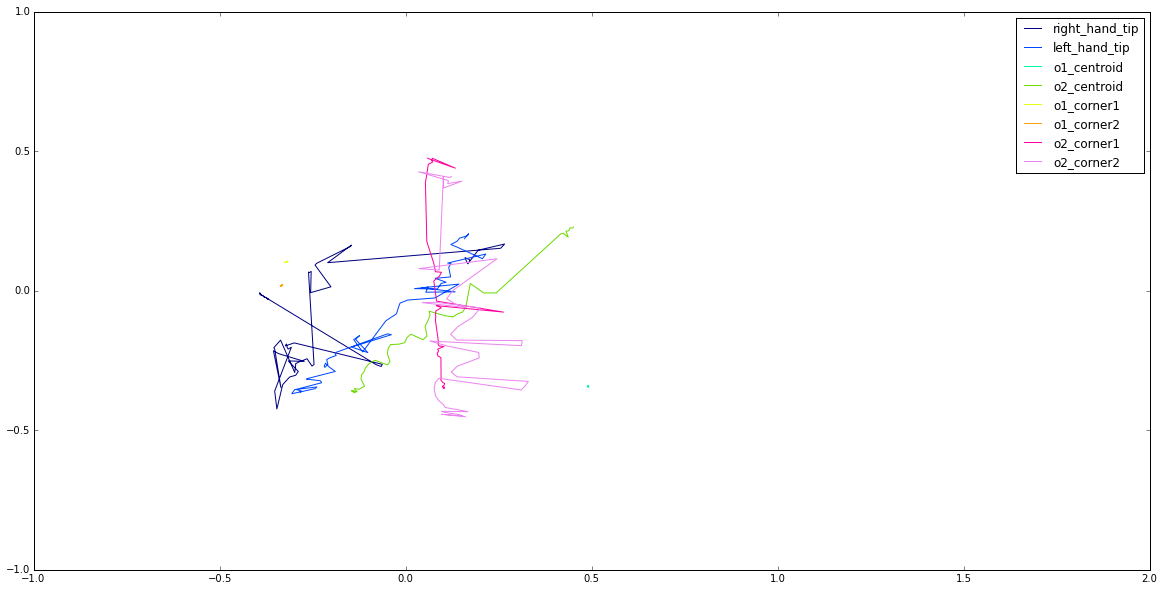

In [72]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollacross')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullacross
-----------------------------------


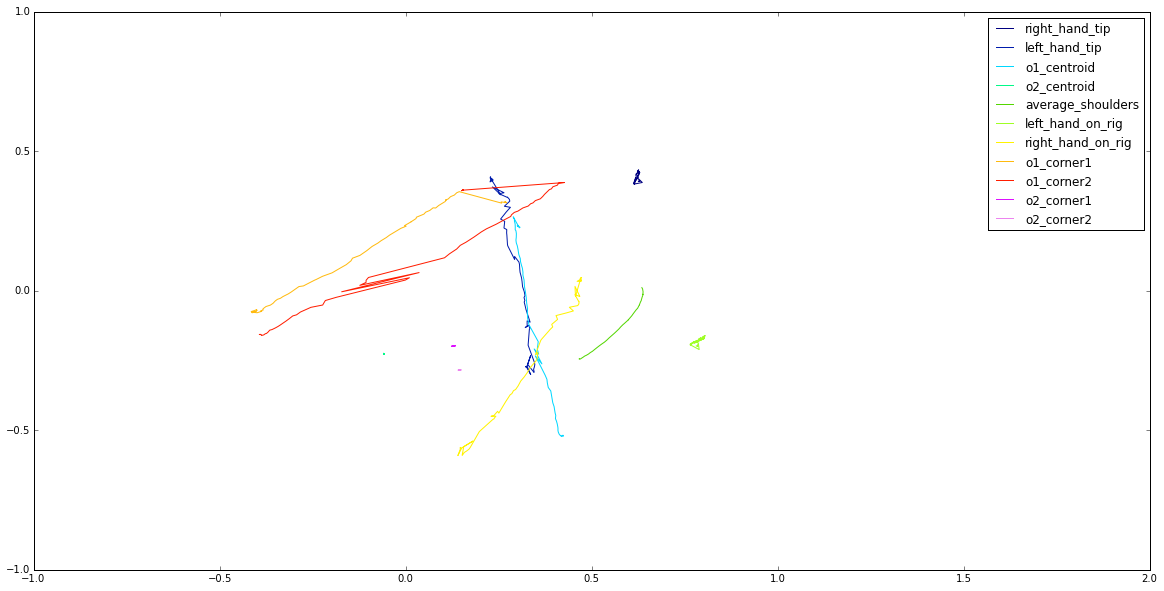

In [65]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullacross', 4)

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullfrom
-----------------------------------


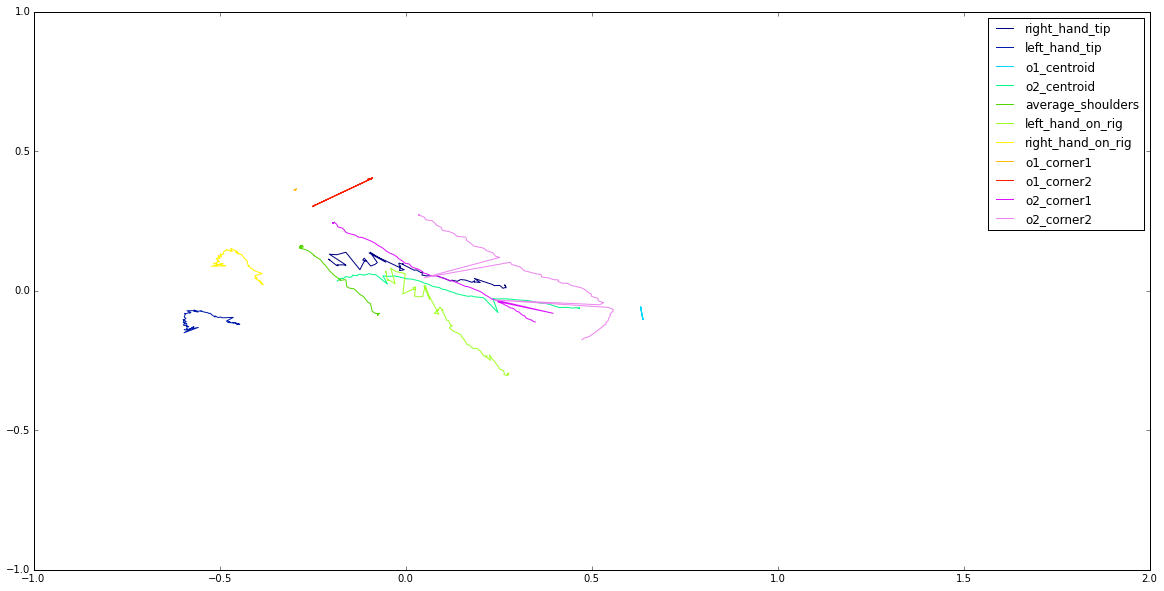

In [66]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullfrom')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pushto
-----------------------------------


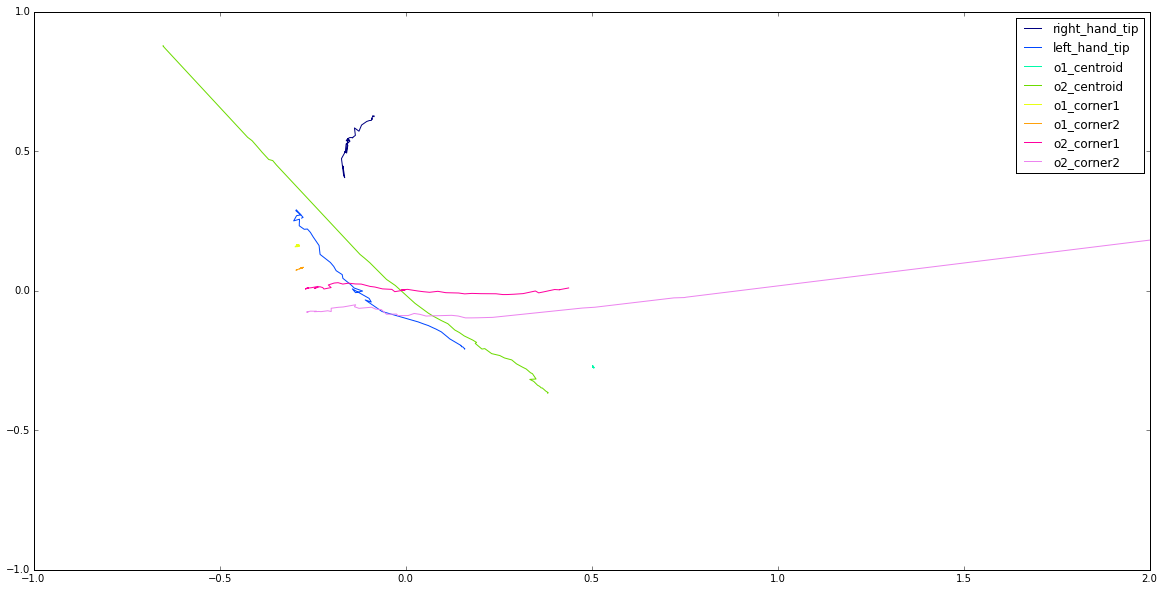

In [73]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pushfrom
-----------------------------------


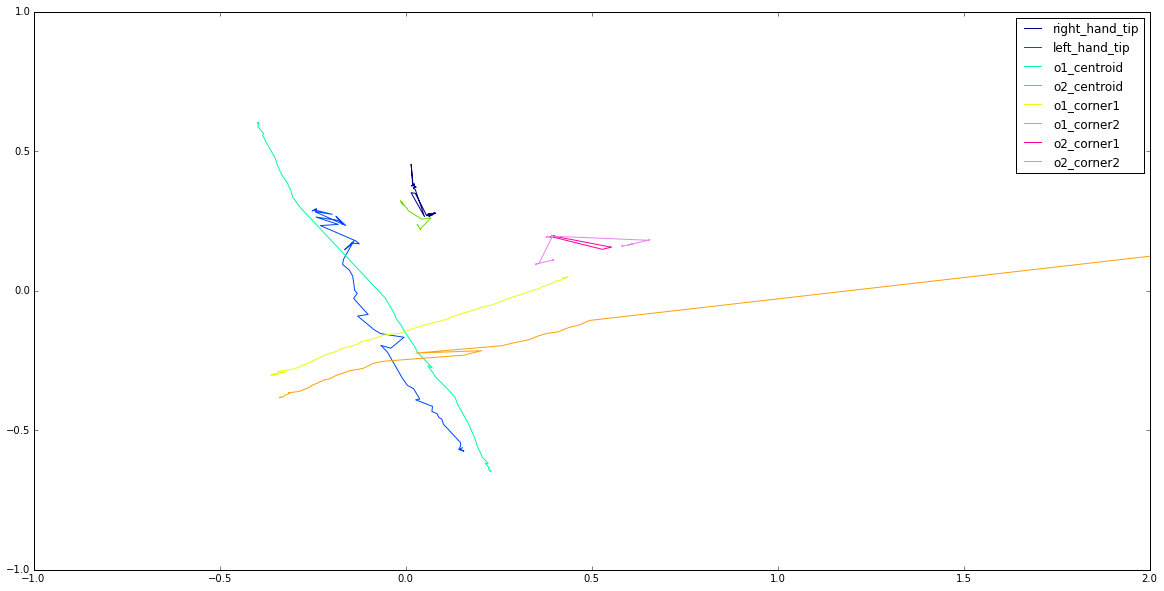

In [74]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pushfrom')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


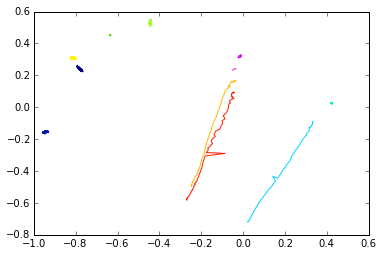

In [22]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


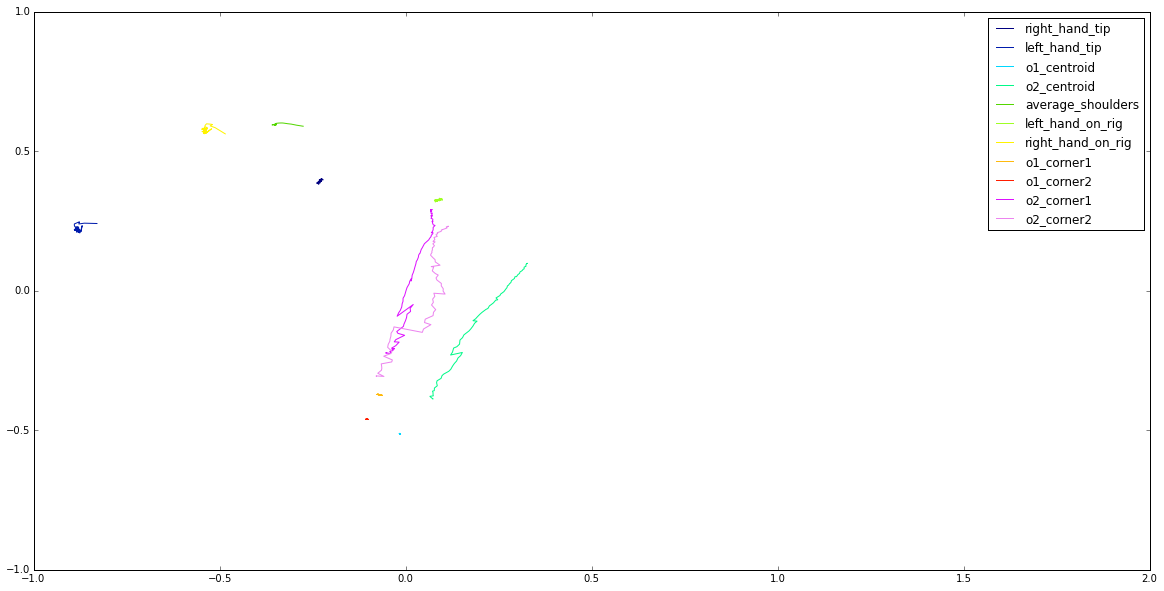

In [61]:
plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto', 1)

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


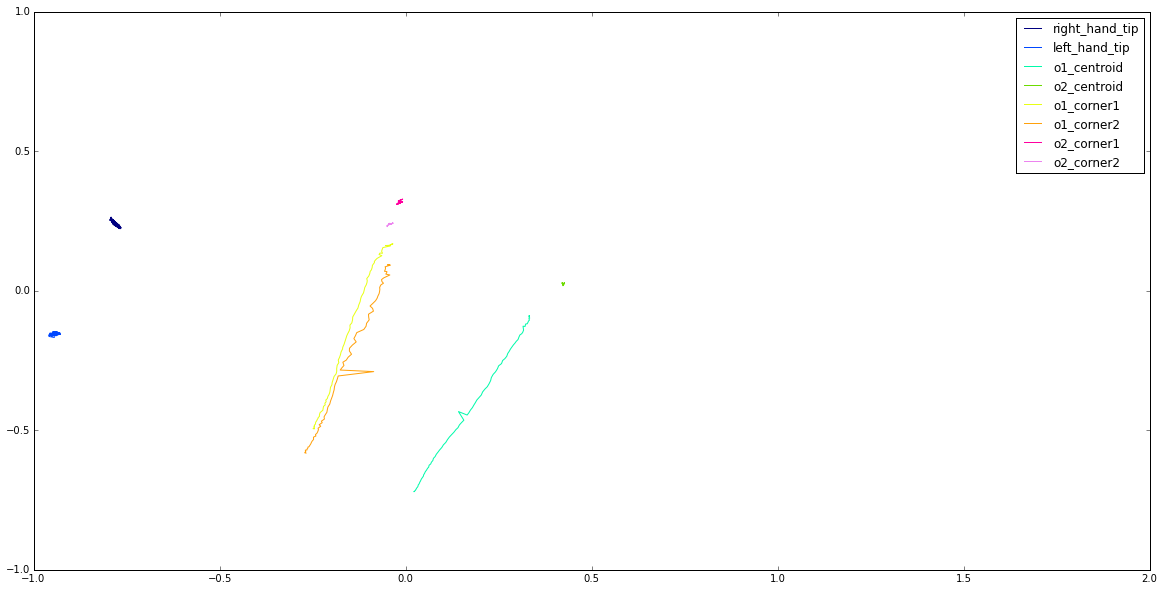

In [76]:
import sys
sys.path.append('C:\Users\Tuan\git\strands_qsr_lib\qsr_lib\src')

In [77]:
from qsrlib.qsrlib import QSRlib, QSRlib_Request_Message

In [78]:
from qsrlib_io.world_trace import Object_State, World_Trace

In [94]:
def pretty_print_world_qsr_trace(which_qsr, qsrlib_response_message):
    print(which_qsr, "request was made at ", str(qsrlib_response_message.req_made_at)
          + " and received at " + str(qsrlib_response_message.req_received_at)
          + " and computed at " + str(qsrlib_response_message.req_finished_at))
    print("---")
    print("Response is:")
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        foo = str(t) + ": "
        for k, v in zip(qsrlib_response_message.qsrs.trace[t].qsrs.keys(),
                        qsrlib_response_message.qsrs.trace[t].qsrs.values()):
            foo += str(k) + ":" + str(v.qsr) + "; "
        print(foo)

In [89]:
qsrlib = QSRlib()

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\selfslideto
-----------------------------------


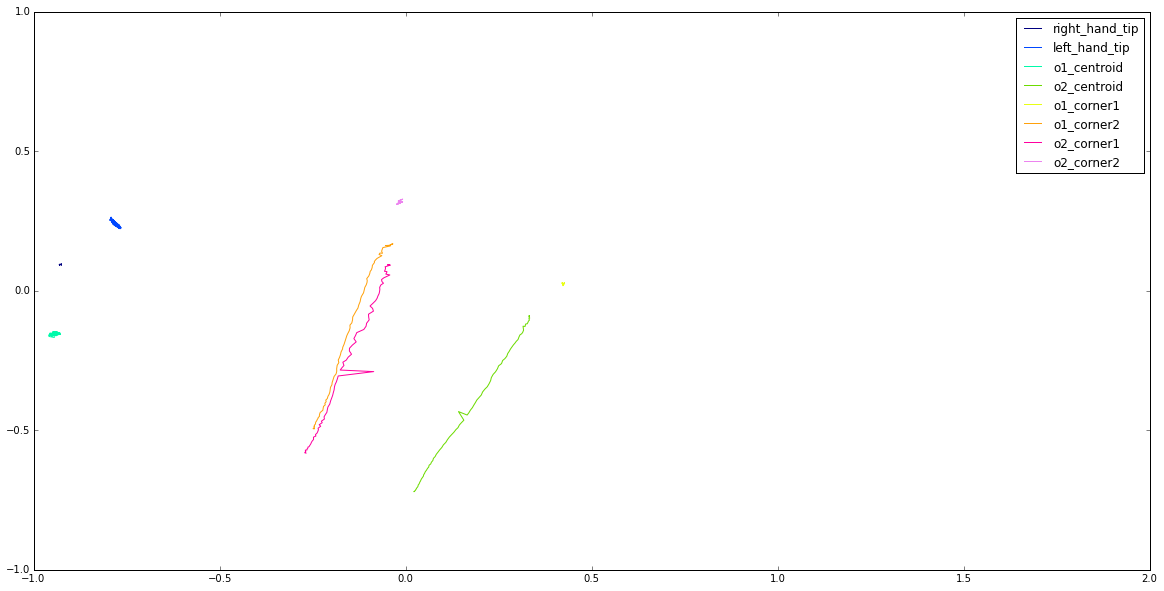

In [192]:
sample = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\selfslideto')

In [188]:
o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=sample[i][8], y=sample[i][9], width=1, length=1) 
      for i in xrange(108)]

o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=sample[i][10], y=sample[i][11], width=1, length=1) 
      for i in xrange(108)]

o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=sample[i][4], y=sample[i][5], width=1, length=1) 
      for i in xrange(108)]

o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=sample[i][6], y=sample[i][7], width=1, length=1) 
      for i in xrange(108)]

world = World_Trace()
world.add_object_state_series(o1_corner1)
world.add_object_state_series(o1_corner2)
world.add_object_state_series(o1_centroid)
world.add_object_state_series(o2_centroid)

qsrlib_request_message = QSRlib_Request_Message(which_qsr=['qtccs', 
                                                           'cardir', 'argd'], input_data=world, 
                dynamic_args = {'qtccs': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                               'cardir': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                               'argd': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')], 
                                        'qsr_relations_and_values' : dict(("" + str(i), i * 1.0 / 20) for i in xrange(20)) }})
# request your QSRs
qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

pretty_print_world_qsr_trace(['qtccs', 
                              'cardir', 'argd'], qsrlib_response_message)

(['qtccs', 'cardir', 'argd'], 'request was made at ', '2017-04-18 15:56:43.206000 and received at 2017-04-18 15:56:43.206000 and computed at 2017-04-18 15:56:43.351000')
---
Response is:
0.0: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2'}; o1_centroid,o2_centroid:{'cardir': 'sw', 'argd': '17'}; 
1: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2', 'qtccs': '-,+,-,-'}; o1_centroid,o2_centroid:{'cardir': 'sw', 'argd': '17', 'qtccs': '-,+,+,+'}; 
2: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2', 'qtccs': '-,+,0,-'}; o1_centroid,o2_centroid:{'cardir': 'sw', 'argd': '17', 'qtccs': '-,0,0,0'}; 
3: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2', 'qtccs': '-,+,+,-'}; o1_centroid,o2_centroid:{'cardir': 'sw', 'argd': '17', 'qtccs': '-,-,-,-'}; 
4: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2', 'qtccs': '0,+,0,-'}; o1_centroid,o2_centroid:{'cardir': 'sw', 'argd': '17', 'qtccs': '0,0,0,0'}; 
5: o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2', 'qtccs': '+,+,-,-'}; o1_centroid,o2_c

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\rollacross
-----------------------------------


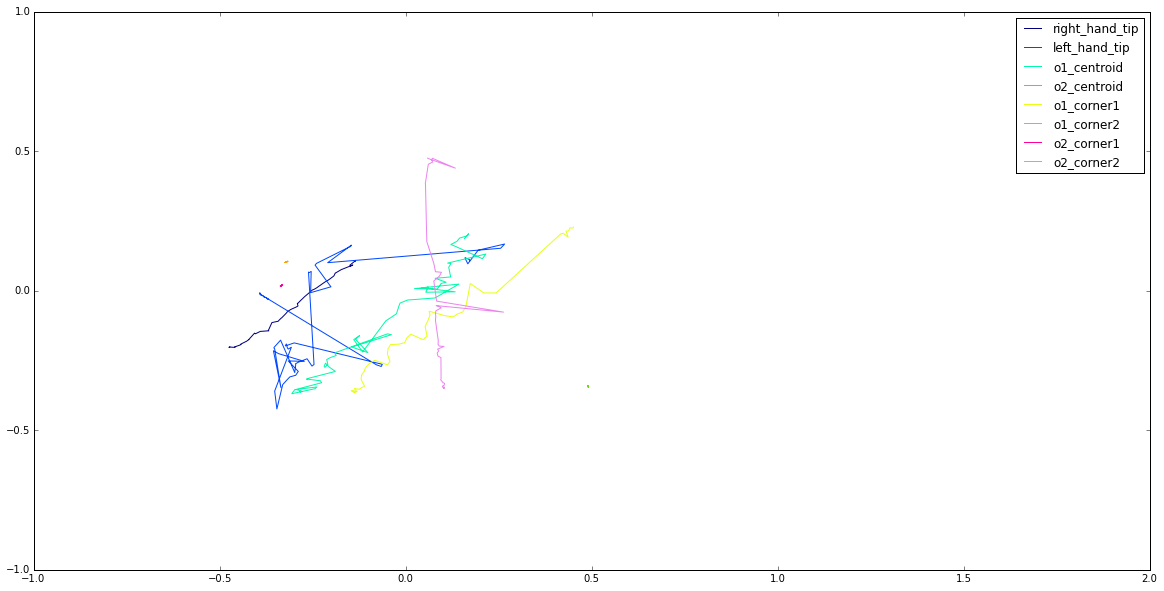

In [219]:
sample2 = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\rollacross')

In [186]:
o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=sample2[i][12], y=sample2[i][13], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=sample2[i][14], y=sample2[i][15], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=sample2[i][4], y=sample2[i][5], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=sample2[i][6], y=sample2[i][7], width=0.1, length=0.1) 
      for i in xrange(sample2.shape[0])]

world = World_Trace()
world.add_object_state_series(o1_corner1)
world.add_object_state_series(o1_corner2)
world.add_object_state_series(o1_centroid)
world.add_object_state_series(o2_centroid)

qsrlib_request_message = QSRlib_Request_Message(which_qsr=[#'qtccs', 
                                                           'cardir', 'mos', 'argd'], input_data=world, 
                dynamic_args = {#'qtccs': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                               'cardir': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')]},
                                'mos' : {'qsrs_for': ['o1_centroid', 'o2_centroid'], 'quantisation_factor': 0.005},
                               'argd': {'qsrs_for': [('o1_corner1', 'o1_corner2'), ('o1_centroid', 'o2_centroid')], 
                                        'qsr_relations_and_values' : dict(("" + str(i), i * 1.0 / 20) for i in xrange(20)) }})
# request your QSRs
qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

pretty_print_world_qsr_trace([#'qtccs', 
                              'cardir', 'mos', 'argd'], qsrlib_response_message)

(['cardir', 'mos', 'argd'], 'request was made at ', '2017-04-18 15:37:17.006000 and received at 2017-04-18 15:37:17.006000 and computed at 2017-04-18 15:37:17.020000')
---
Response is:
0.0: o1_corner1,o1_corner2:{'cardir': 'nw', 'argd': '3'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
1.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '2'}; o2_centroid:{'mos': 'm'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
2.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '3'}; o2_centroid:{'mos': 'm'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
3.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'nw', 'argd': '3'}; o2_centroid:{'mos': 's'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
4.0: o1_centroid:{'mos': 's'}; o1_corner1,o1_corner2:{'cardir': 'n', 'argd': '3'}; o2_centroid:{'mos': 's'}; o1_centroid,o2_centroid:{'cardir': 'e', 'argd': '13'}; 
5.0: o1_centroid:{'mos': 's'}; o1_corner

In [236]:
cdid = dict( (u, i) for (i, u) in enumerate( ['n', 'nw', 'w', 'sw', 's', 'se', 'e', 'ne'] ))
mosd = dict( (u, i) for (i, u) in enumerate( ['s', 'm'] ))

def cardir_index ( cardir ):
    return cdid [cardir]

def mos_index ( mos ):
    return mosd [mos]

def turn_response_to_features(keys, qsrlib_response_message):
    feature_chain = []
    for t in qsrlib_response_message.qsrs.get_sorted_timestamps():
        features = []
        # print (qsrlib_response_message.qsrs.trace[t].qsrs.keys())
        for k in keys:
            if k in qsrlib_response_message.qsrs.trace[t].qsrs:
                v = qsrlib_response_message.qsrs.trace[t].qsrs[k]

                if 'cardir' in v.qsr:
                    f = v.qsr['cardir']
                    features.append(cardir_index(f))
                if 'argd' in v.qsr:
                    f = int( v.qsr['argd'] )
                    features.append(f)
                if 'mos' in v.qsr:
                    f = v.qsr['mos'] 
                    features.append(mos_index(f))
                
        feature_chain.append(features)
    
    feature_chain[0] += [0, 0, 0]
    
    feature_chain = [ [feature_chain[t + 1][i] - feature_chain[t][i] for i in xrange(len(feature_chain[0])) ]
                  for t in xrange(len(feature_chain) - 1)]
    
    feature_chain = [[0 for i in xrange(len(feature_chain[0]))]] +  feature_chain
    return feature_chain
        

def qsr_feature_extractor ( qsrlib, session_data ):
    # body centroid
    body_centroid = [Object_State(name="body", timestamp=i, x=session_data[i][0], y=session_data[i][1], width=0.1, length=0.1) 
      for i in xrange(session_data.shape[0])]
    
    # left hand tip
    left_hand = [Object_State(name="left_hand", timestamp=i, x=session_data[i][2], y=session_data[i][3], width=0.1, length=0.1) 
      for i in xrange(session_data.shape[0])]
    
    # right hand tip
    right_hand = [Object_State(name="right_hand", timestamp=i, x=session_data[i][4], y=session_data[i][5], width=0.1, length=0.1) 
      for i in xrange(session_data.shape[0])]
    
    # centroid of o1 object
    o1_centroid = [Object_State(name="o1_centroid", timestamp=i, x=session_data[i][6], y=session_data[i][7], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]
    
    # centroid of o2 object
    o2_centroid = [Object_State(name="o2_centroid", timestamp=i, x=session_data[i][8], y=session_data[i][9], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]
    
    # o1
    o1_corner1 = [Object_State(name="o1_corner1", timestamp=i, x=session_data[i][10], y=session_data[i][11], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]
    
    o1_corner2 = [Object_State(name="o1_corner2", timestamp=i, x=session_data[i][12], y=session_data[i][13], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]
    
    # o2
    o2_corner1 = [Object_State(name="o2_corner1", timestamp=i, x=session_data[i][14], y=session_data[i][15], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]
    
    o2_corner2 = [Object_State(name="o2_corner2", timestamp=i, x=session_data[i][16], y=session_data[i][17], width=0.1, length=0.1) 
          for i in xrange(session_data.shape[0])]

    

    world = World_Trace()
    world.add_object_state_series(body_centroid)
    world.add_object_state_series(left_hand)
    world.add_object_state_series(right_hand)
    world.add_object_state_series(o1_centroid)
    world.add_object_state_series(o2_centroid)
    world.add_object_state_series(o1_corner1)
    world.add_object_state_series(o1_corner2)
    world.add_object_state_series(o2_corner1)
    world.add_object_state_series(o2_corner2)
    
    interest_argd_pairs = [('body', 'left_hand'), ('body', 'right_hand'), ('left_hand', 'o1_centroid'), 
                           ('right_hand', 'o1_centroid'), ('left_hand', 'o2_centroid'), 
                           ('right_hand', 'o2_centroid'), ('o1_centroid', 'o2_centroid'), 
                           ('o1_corner1','o1_corner2'), ('o2_corner1','o2_corner2')]
    interest_cardir_pairs = interest_argd_pairs
    
    interest_argd_pair_keys = [u + ',' + v for (u, v) in interest_argd_pairs]
    
    interest_mos_elements = ['body', 'o1_centroid', 'o2_centroid']
    
    qsrlib_request_message = QSRlib_Request_Message(which_qsr=['cardir', 'mos', 'argd'], input_data=world, 
                    dynamic_args = {'cardir': {'qsrs_for': interest_cardir_pairs},
                                    'mos' : {'qsrs_for': interest_mos_elements, 'quantisation_factor': 0.005},
                                    'argd': {'qsrs_for': interest_argd_pairs, 
                                            'qsr_relations_and_values' : dict(("" + str(i), i * 1.0 / 20) for i in xrange(20)) }})
    # request your QSRs
    qsrlib_response_message = qsrlib.request_qsrs(req_msg=qsrlib_request_message)

    # pretty_print_world_qsr_trace(['cardir', 'mos', 'argd'], qsrlib_response_message)
    
    return turn_response_to_features(interest_argd_pair_keys + interest_mos_elements, qsrlib_response_message)

In [237]:
qsr_feature_extractor( qsrlib, sample)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 

In [232]:
qsr_feature_extractor( qsrlib, sample2)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0],
 [0, -1, 0, 0, -2, 1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, -1, 0],
 [0, 0, 0, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1],
 [0, 0, -1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 1, -1, 3, -1, -1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, -2, 0, 0, -3, 1, 0, 0, 0, -2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 2, -1, 1, 5, -1, 1, -1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
 [0, -2, 1, -1, -6, 2, -1, 1, 0, -3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, -1],
 [0, 0, 0, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [-1, 1, -1, 1, 4, -1, 0, -2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, -1, 0, 0, -3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0],
 [0, 1, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 

-----------------------------------
C:\Users\Tuan\git\ecat_learning\data\pullacross
-----------------------------------


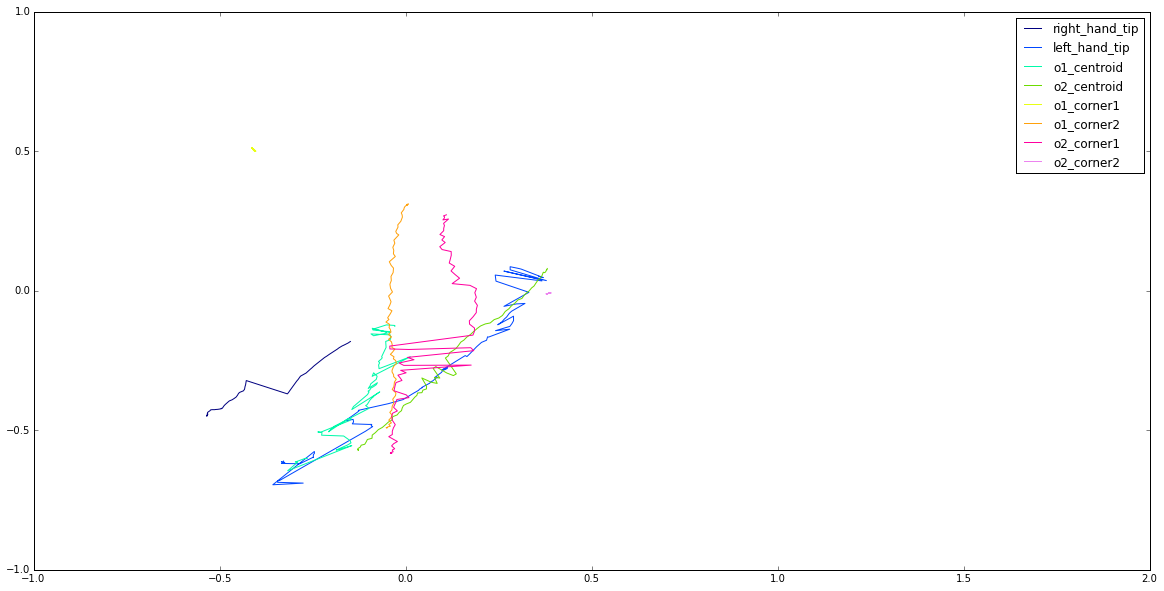

In [222]:
sample3 = plot_project('C:\\Users\\Tuan\\git\\ecat_learning\\data\\pullacross')

In [223]:
qsr_feature_extractor( qsrlib, sample3)

[[3, 12, 3, 3, 3, 1, 3, 10, 5, 18, 5, 15, 5, 18, 2, 3, 2, 19],
 [3, 12, 3, 3, 3, 1, 3, 10, 5, 18, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 0],
 [3, 12, 3, 3, 4, 1, 3, 10, 5, 18, 5, 15, 5, 18, 1, 3, 2, 19, 0, 0, 0],
 [3, 11, 3, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 19, 2, 3, 2, 19, 0, 1, 1],
 [3, 11, 3, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 1],
 [3, 11, 3, 2, 2, 2, 3, 11, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 0, 0],
 [3, 11, 2, 3, 2, 2, 3, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 3, 2, 5, 1, 2, 10, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 10, 3, 2, 2, 2, 2, 10, 5, 17, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 2, 3, 7, 1, 3, 9, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 0],
 [3, 12, 2, 3, 7, 1, 3, 9, 5, 19, 5, 15, 5, 18, 2, 3, 2, 19, 0, 1, 1],
 [3, 10, 3, 2, 1, 3, 2, 10, 5, 16, 5, 15, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [3, 10, 3, 2, 2, 2, 2, 10, 5, 16, 5, 15, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [2, 11, 2, 3, 6, 1, 2, 8, 5, 18, 5, 16, 5, 18, 2, 3, 2, 19, 1, 1, 0],
 [2,